## ADs CTR prediction 
The dataset below was submitted by Gaurav Dutta on Kaggle. Below are all the features in the dataset:

Daily Time Spent on Site: the daily timespan of the user on the website;

Age: the age of the user;

Area Income: the average income in the area of the user;

Daily Internet Usage: the daily internet usage of the user;

Ad Topic Line: the title of the ad;

City: the city of the user;

Gender: the gender of the user;

Country: the country of the user;

Timestamp: the time when the user visited the website;

Clicked on Ad: 1 if the user clicked on the ad, otherwise 0;

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

sns.set(style="whitegrid")
%matplotlib inline


In [34]:
data = pd.read_csv("AdsCTR.csv")

print("First 5 rows of the dataset:")
print(data.head())


First 5 rows of the dataset:
   Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
0                     62.26  32.0     69481.85                172.83   
1                     41.73  31.0     61840.26                207.17   
2                     44.40  30.0     57877.15                172.83   
3                     59.88  28.0     56180.93                207.17   
4                     49.21  30.0     54324.73                201.58   

                         Ad Topic Line             City  Gender  \
0      Decentralized real-time circuit         Lisafort    Male   
1       Optional full-range projection  West Angelabury    Male   
2  Total 5thgeneration standardization        Reyesfurt  Female   
3          Balanced empowering success      New Michael  Female   
4  Total 5thgeneration standardization     West Richard  Female   

                        Country            Timestamp  Clicked on Ad  
0  Svalbard & Jan Mayen Islands  2016-06-09 21:43:05             

In [35]:
print("\nMissing values before handling:")
print(data.isnull().sum())



Missing values before handling:
Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Gender                      0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64


In [36]:
numerical_features = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
for feature in numerical_features:
    if data[feature].isnull().sum() > 0:
        median_value = data[feature].median()
        data[feature].fillna(median_value, inplace=True)
        print(f"Filled NaNs in {feature} with median value {median_value}")

categorical_features = ['Gender', 'Country']
for feature in categorical_features:
    if data[feature].isnull().sum() > 0:
        mode_value = data[feature].mode()[0]
        data[feature].fillna(mode_value, inplace=True)
        print(f"Filled NaNs in {feature} with mode value '{mode_value}'")


In [37]:
print("\nMissing values after handling:")
print(data.isnull().sum())




Missing values after handling:
Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Gender                      0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64


## Mapping target variable

In [38]:
data["Clicked on Ad"] = data["Clicked on Ad"].map({0: "No", 1: "Yes"})

print("\nValue counts for 'Clicked on Ad':")
print(data["Clicked on Ad"].value_counts())



Value counts for 'Clicked on Ad':
Clicked on Ad
No     5083
Yes    4917
Name: count, dtype: int64


## Defining the CTR bar plot function


In [39]:
def plot_ctr_bar(data, feature, bins=10, title="CTR by Feature"):
    binned = pd.cut(data[feature], bins=bins)
    binned_str = binned.astype(str)

    ctr = data.groupby(binned_str)["Clicked on Ad"].value_counts(normalize=True).unstack()

    ctr.plot(kind='bar', stacked=True, figsize=(12, 7), color=['red', 'blue'])
    plt.title(f"Click Through Rate based on {feature}")
    plt.xlabel(f"{feature} (Binned)")
    plt.ylabel("Proportion")
    plt.legend(title='Clicked on Ad', labels=['No', 'Yes'])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


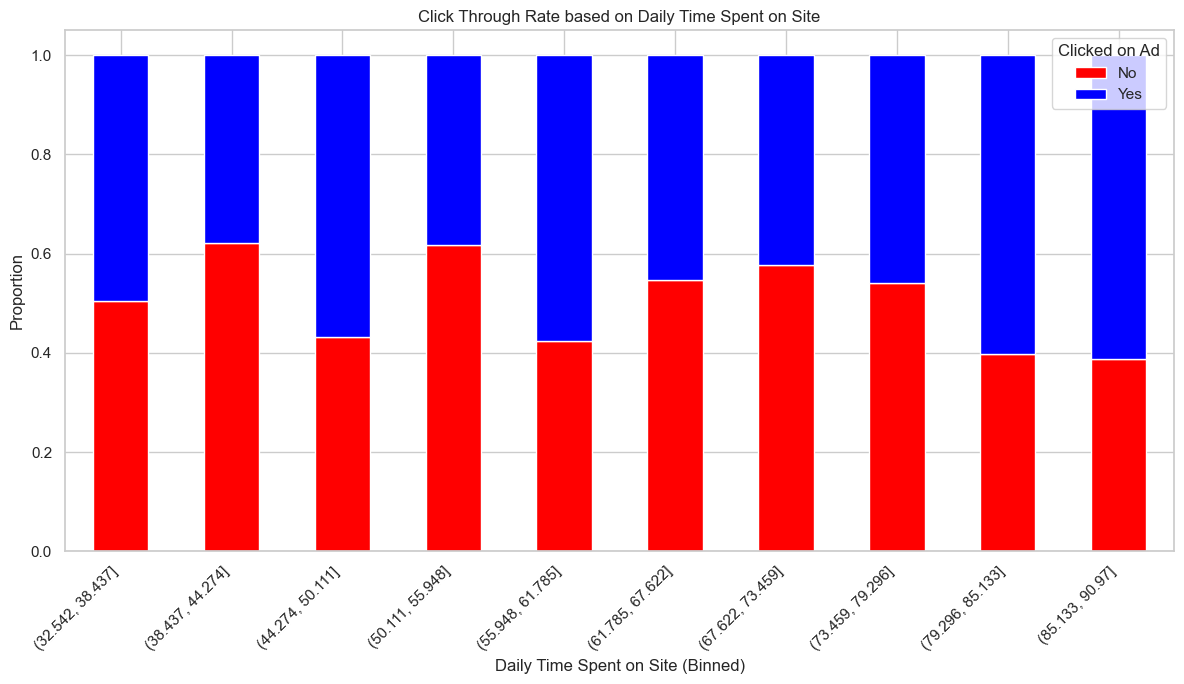

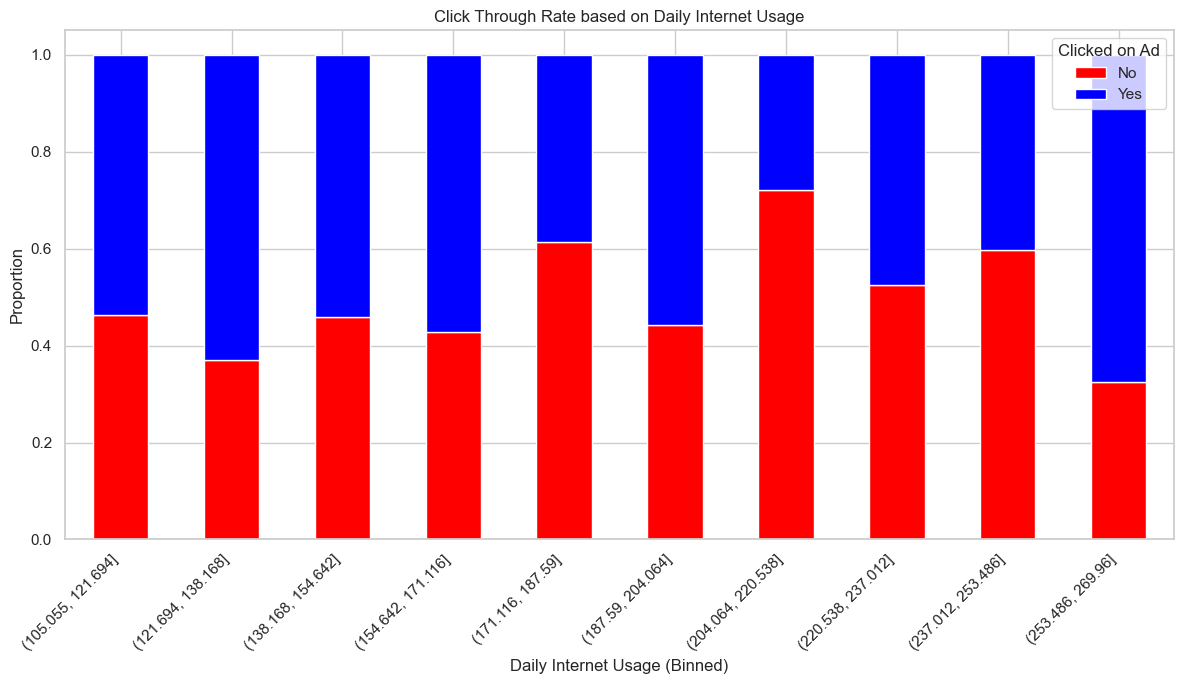

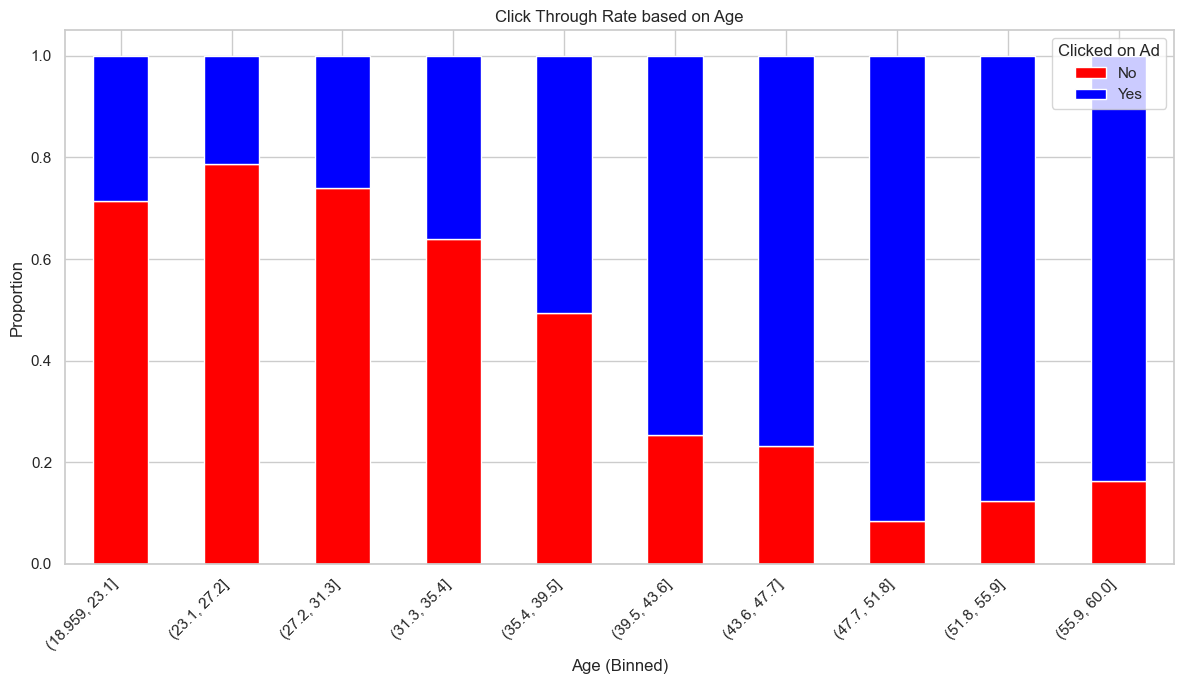

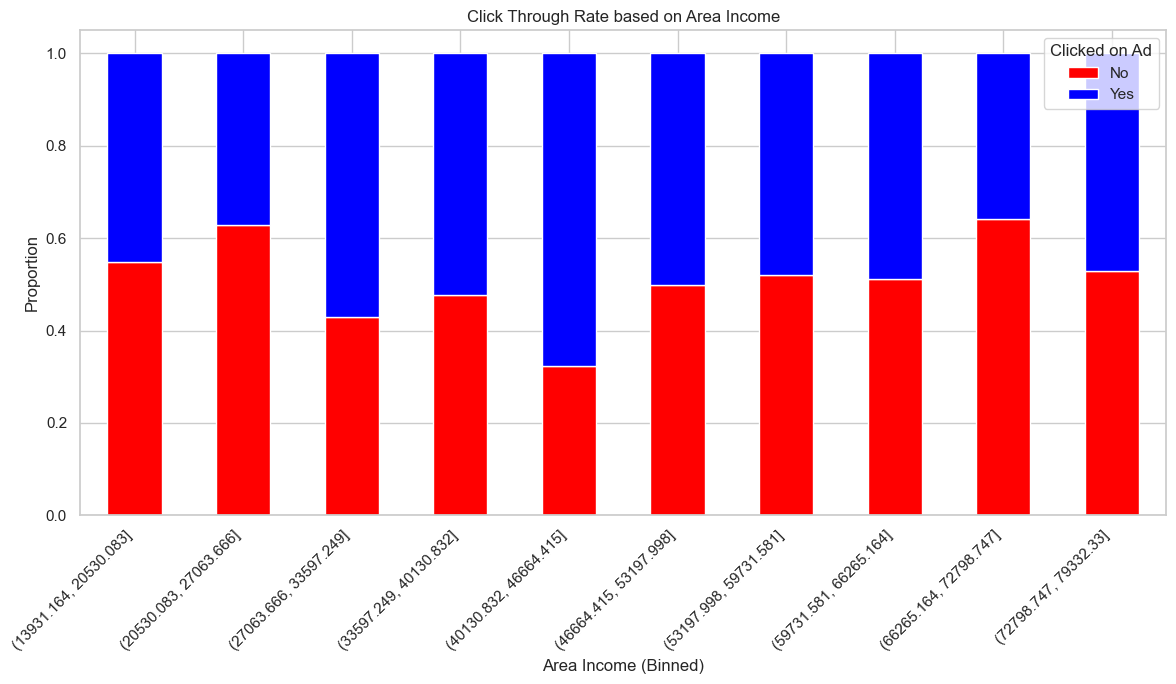

In [40]:
plot_ctr_bar(data, 'Daily Time Spent on Site', bins=10, title="CTR by Daily Time Spent on Site")

plot_ctr_bar(data, 'Daily Internet Usage', bins=10, title="CTR by Daily Internet Usage")

plot_ctr_bar(data, 'Age', bins=10, title="CTR by Age")

plot_ctr_bar(data, 'Area Income', bins=10, title="CTR by Area Income")



## Calculating overall CTR

In [41]:
overall_ctr = data["Clicked on Ad"].value_counts(normalize=True) * 100
print("\nOverall Click Through Rate:")
print(overall_ctr)
print(f"Overall Click Through Rate: {overall_ctr.get('Yes', 0):.2f}%")



Overall Click Through Rate:
Clicked on Ad
No     50.83
Yes    49.17
Name: proportion, dtype: float64
Overall Click Through Rate: 49.17%


In [42]:
data["Gender"] = data["Gender"].map({"Male": 1, "Female": 0})

data = pd.get_dummies(data, columns=['Country'], drop_first=True)
print("\nData after encoding categorical variables:")
print(data.head())



Data after encoding categorical variables:
   Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
0                     62.26  32.0     69481.85                172.83   
1                     41.73  31.0     61840.26                207.17   
2                     44.40  30.0     57877.15                172.83   
3                     59.88  28.0     56180.93                207.17   
4                     49.21  30.0     54324.73                201.58   

                         Ad Topic Line             City  Gender  \
0      Decentralized real-time circuit         Lisafort       1   
1       Optional full-range projection  West Angelabury       1   
2  Total 5thgeneration standardization        Reyesfurt       0   
3          Balanced empowering success      New Michael       0   
4  Total 5thgeneration standardization     West Richard       0   

             Timestamp Clicked on Ad  Country_Albania  ...  \
0  2016-06-09 21:43:05            No            False  ...

## preparing feature matrix and target vector

In [43]:
bin_columns = [col for col in data.columns if 'Bin' in col]

X = data.drop(['Ad Topic Line', 'City', 'Clicked on Ad', 'Timestamp'] + bin_columns, axis=1, errors='ignore')
y = data["Clicked on Ad"].map({"No": 0, "Yes": 1})  
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")



Feature matrix shape: (10000, 211)
Target vector shape: (10000,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=4
)

print(f"\nTraining feature matrix shape: {X_train.shape}")
print(f"Testing feature matrix shape: {X_test.shape}")
print(f"Training target vector shape: {y_train.shape}")
print(f"Testing target vector shape: {y_test.shape}")



Training feature matrix shape: (8000, 211)
Testing feature matrix shape: (2000, 211)
Training target vector shape: (8000,)
Testing target vector shape: (2000,)


In [45]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("\nRandom Forest model trained successfully.")



Random Forest model trained successfully.


In [46]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)



Model Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1049
           1       0.82      0.82      0.82       951

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



## visualising feature importance


/var/folders/p1/2ml0fv9x7x79s1nnddt1_10h0000gn/T/ipykernel_2001/1458244218.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




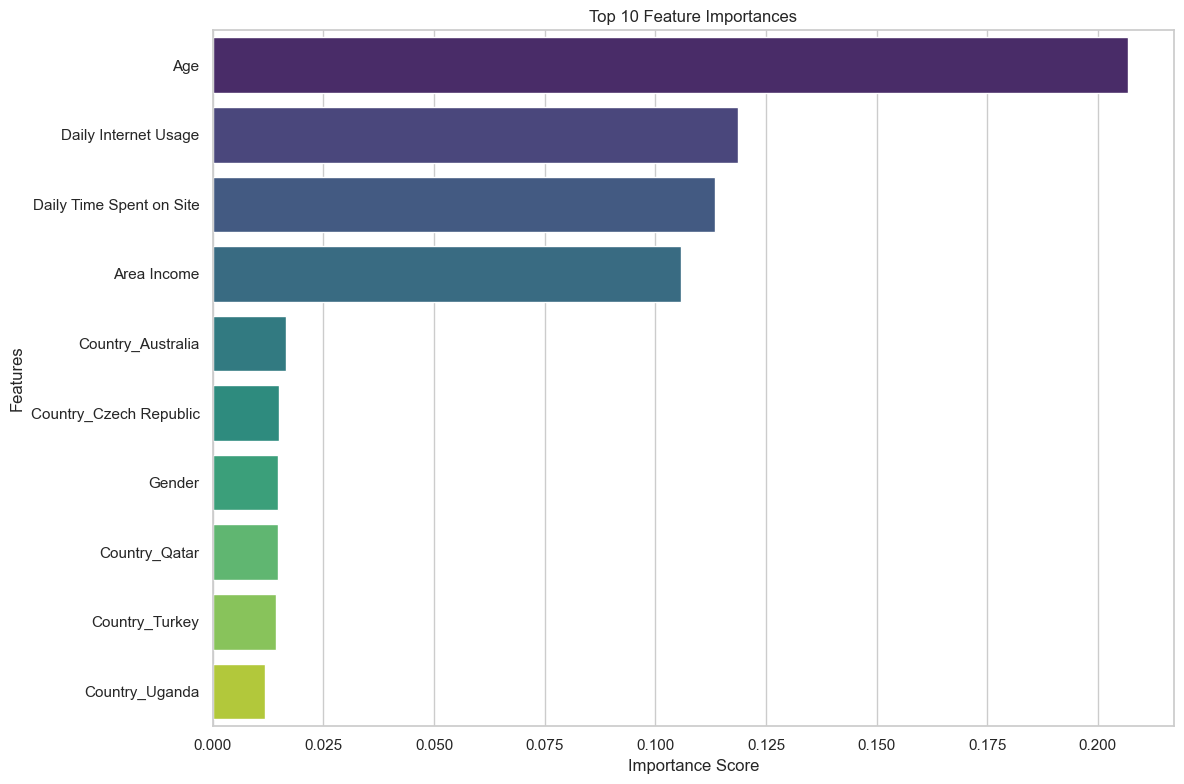

In [47]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[:10], y=feature_importances[:10].index, palette='viridis')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [48]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
optimized_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nOptimized Model Accuracy: {optimized_accuracy:.2f}")
optimized_report = classification_report(y_test, y_pred_best)
print("\nOptimized Classification Report:")
print(optimized_report)



Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Optimized Model Accuracy: 0.84

Optimized Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1049
           1       0.83      0.84      0.84       951

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



In [49]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Accuracy: {cv_scores.std():.2f}")



Cross-Validation Accuracy Scores: [0.838  0.8325 0.8325 0.8455 0.8245]
Mean CV Accuracy: 0.83
Standard Deviation of CV Accuracy: 0.01


In [50]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("\nClass distribution after applying SMOTE:")
print(pd.Series(y_train_res).value_counts())


model_resampled = RandomForestClassifier(random_state=42)
model_resampled.fit(X_train_res, y_train_res)
y_pred_res = model_resampled.predict(X_test)
accuracy_res = accuracy_score(y_test, y_pred_res)
print(f"\nResampled Model Accuracy: {accuracy_res:.2f}")
print("\nResampled Classification Report:")
print(classification_report(y_test, y_pred_res))



Class distribution after applying SMOTE:
Clicked on Ad
1    4034
0    4034
Name: count, dtype: int64

Resampled Model Accuracy: 0.83

Resampled Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1049
           1       0.82      0.82      0.82       951

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

